In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

data = pd.read_csv(os.path.join('dataset', 'data_num.csv'))
target = pd.read_csv(os.path.join('dataset', 'target_num.csv'))
feature = data.columns

base_info_idx = 13

## 不同标准下，主要养育风险因素

In [89]:

def outRisk(df, featureName, fp=None):
    if fp :
        for i in df[featureName].unique():
            dfi = df[df[featureName] == i]

            column_sums = dfi.iloc[:, 13:].sum(axis=0) # 对每一列求和
            q15 = column_sums.quantile(0.15)
            sorted_sums = column_sums.sort_values()
            columns_below_q15 = sorted_sums[sorted_sums.lt(q15)].index

            print(f'{featureName} == {i} 的后15%的特征:', file=fp)
            for column in columns_below_q15:
                print(column, file=fp)
            print(file=fp)
    else:
        for i in df[featureName].unique():
            dfi = df[df[featureName] == i]

            column_sums = dfi.iloc[:, 13:].sum(axis=0) # 对每一列求和
            q15 = column_sums.quantile(0.15)
            sorted_sums = column_sums.sort_values()
            columns_below_q15 = sorted_sums[sorted_sums.lt(q15)].index

            print(f'{featureName} == {i} 的后15%的特征:')
            for column in columns_below_q15:
                print(column)
            print()

In [90]:
fp = open(os.path.join('out', 'risk.txt'), 'w+')

for i in feature[1:base_info_idx]:
    outRisk(data, i, fp)

fp.close()

## 基本信息对总分的影响

例如父母年龄，孩子个数，孩子年龄，探究这些属性不同时对总分的影响

方法：**t检验**  
选取以上一个特征进行分组，两两做t检验，检验总分的均值差是否为0

In [91]:
feature[1:base_info_idx]

Index(['您宝宝的性别', '(1)您有几个孩子', '(2)个孩子，这是您的第___个孩子', '宝宝的主要抚养人', '请问宝宝的家庭类型是',
       '宝宝母亲的年龄（周岁）', '宝宝母亲的文化程度:', '宝宝父亲的年龄（周岁）', '宝宝父亲文化的程度:',
       '最近一年，您家庭经济情况如何:', '您宝宝本次体检的社区属于什么区？', '您的宝宝年龄'],
      dtype='object')

In [92]:
decoder = lambda a : dict(zip( range(len(a)), a )) # 此处做了 key - value 反转 (相较于demoA中的代码)
dicList = [
    decoder([0, '直接访问']),
    decoder(['男', '女']),
    {},
    {},
    decoder(['保姆阿姨', '父母', '外祖父母或祖父母', '其他']), # 宝宝的主要抚养人
    decoder(['联合家庭（宝宝、父母、祖父母（或外祖父母）三代一起居住）','核心家庭（宝宝与父母一起居住）','其他（单亲、再婚等）']), # 请问宝宝的家庭类型是
    {}, # 宝宝母亲的年龄（周岁）
    decoder(['初中及以下','本科','大专','高中及中专','研究生','博士生']), # 宝宝母亲的文化程度:
    {}, # 宝宝父亲的年龄（周岁）
    decoder(['初中及以下','本科','大专','高中及中专','研究生','博士生']), # 宝宝父亲文化的程度:
    decoder(['很好','一般','比较差','比较好','很差']), # 最近一年，您家庭经济情况如何:
    decoder(['县级市', '涉农区', '城区']), # 您宝宝本次体检的社区属于什么区？
    decoder(['0~1岁', '3~6岁', '1~3岁']), # 您的宝宝年龄
]

encoder = lambda i, dic : dic[i] if dic else i

print(dicList)

[{0: 0, 1: '直接访问'}, {0: '男', 1: '女'}, {}, {}, {0: '保姆阿姨', 1: '父母', 2: '外祖父母或祖父母', 3: '其他'}, {0: '联合家庭（宝宝、父母、祖父母（或外祖父母）三代一起居住）', 1: '核心家庭（宝宝与父母一起居住）', 2: '其他（单亲、再婚等）'}, {}, {0: '初中及以下', 1: '本科', 2: '大专', 3: '高中及中专', 4: '研究生', 5: '博士生'}, {}, {0: '初中及以下', 1: '本科', 2: '大专', 3: '高中及中专', 4: '研究生', 5: '博士生'}, {0: '很好', 1: '一般', 2: '比较差', 3: '比较好', 4: '很差'}, {0: '县级市', 1: '涉农区', 2: '城区'}, {0: '0~1岁', 1: '3~6岁', 2: '1~3岁'}]


In [93]:
divide_10 = lambda x : x // 10
data['宝宝母亲的年龄（周岁）'] = data['宝宝母亲的年龄（周岁）'].apply(divide_10)
data['宝宝父亲的年龄（周岁）'] = data['宝宝父亲的年龄（周岁）'].apply(divide_10)

In [94]:
from scipy.stats import ttest_ind

# 假设data是一个DataFrame，其中包含了各个特征和总分
cnt = 0
fp = open('out/t-test.txt', 'w+')
for feature_name in feature[1:base_info_idx]:
    cnt += 1
    # 获取当前特征的唯一值
    unique_values = data[feature_name].unique()
    print(feature_name, file=fp)
    # 初始化一个列表来存储每个唯一值对应的总分数据
    groups_scores = []
    
    for value in unique_values:
        # 根据当前特征值分组，并获取这些组的总分
        group_scores = target[data[feature_name] == value]
        groups_scores.append(group_scores)
    
    # 对所有组进行两两t检验
    for i in range(len(groups_scores)):
        for j in range(i + 1, len(groups_scores)):
            # 进行t检验
            t_stat, p_val = ttest_ind(groups_scores[i], groups_scores[j], equal_var=False)
            if p_val < 0.05:
                # print(unique_values[i], unique_values[j])
                print(f"拒绝假设的组（{encoder(unique_values[i], dicList[cnt])} vs {encoder(unique_values[j], dicList[cnt])}）: t统计量={t_stat}, p值={p_val}", 
                      file=fp)
fp.close()


## 总体分析

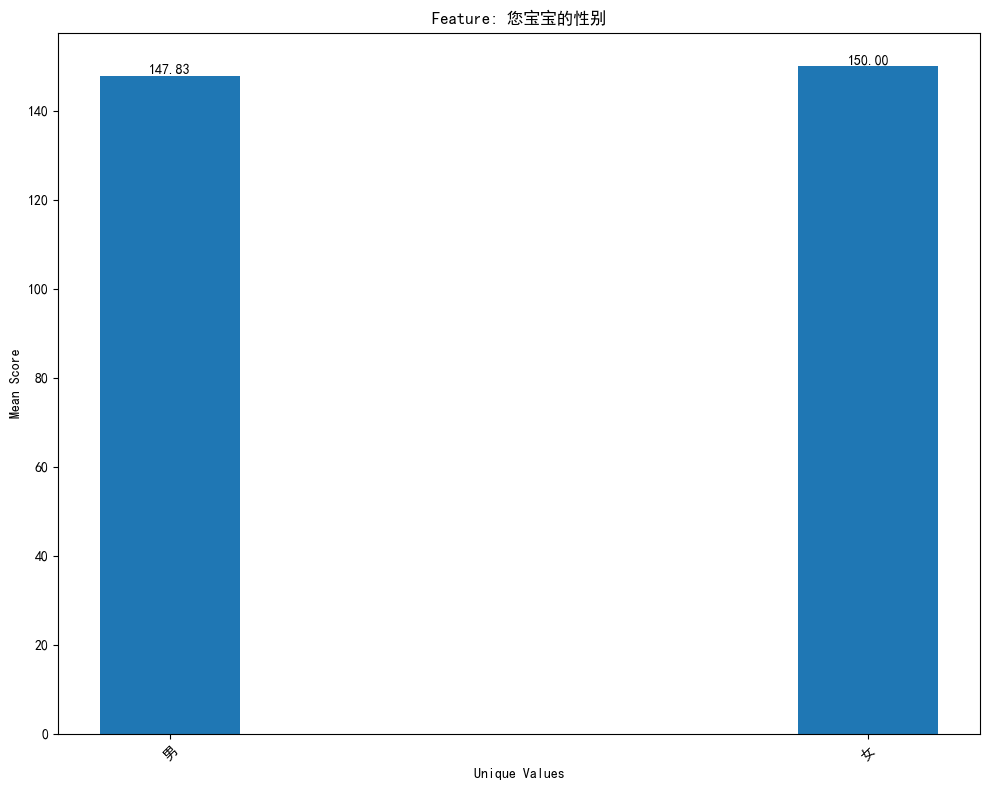

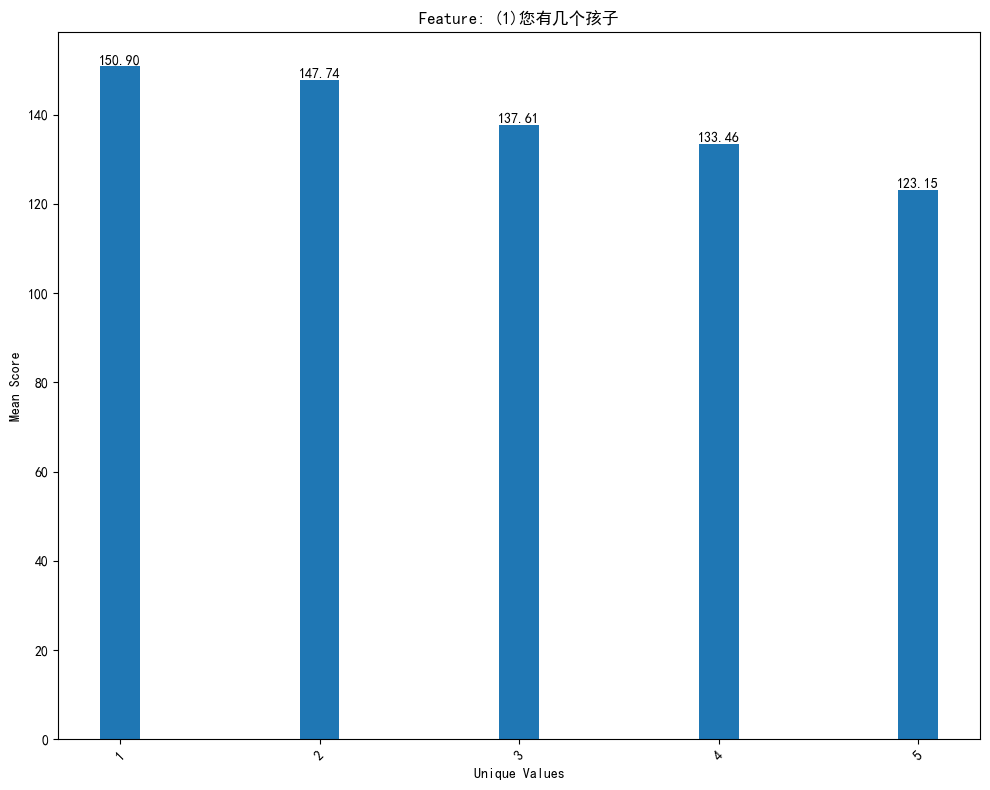

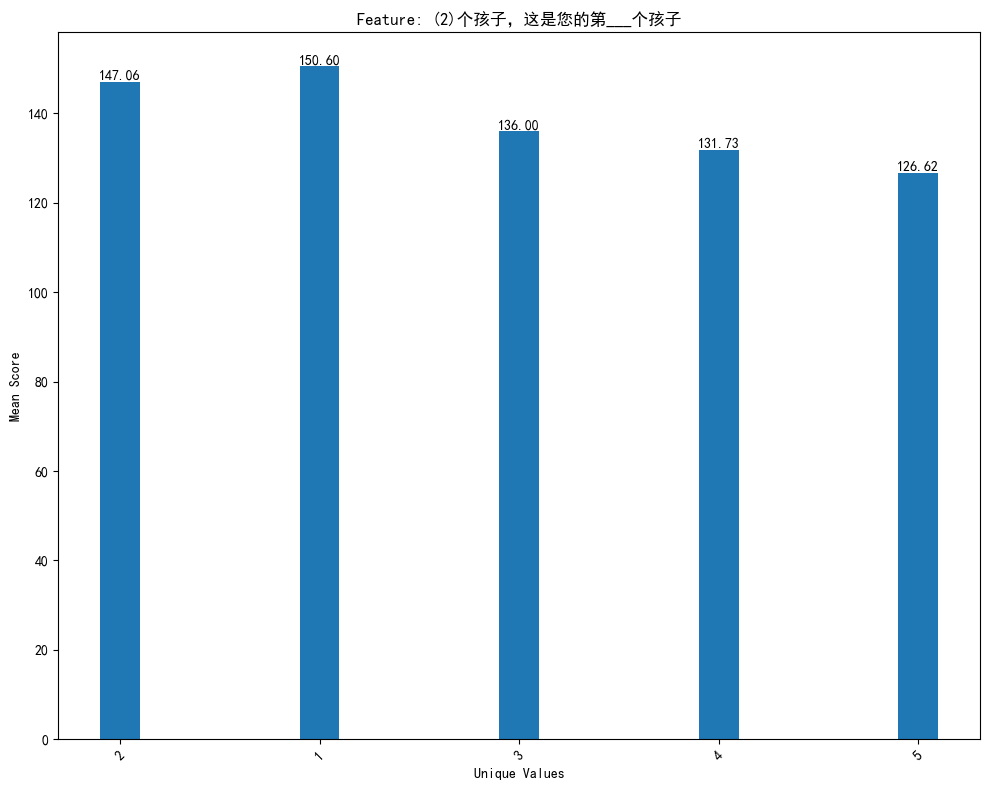

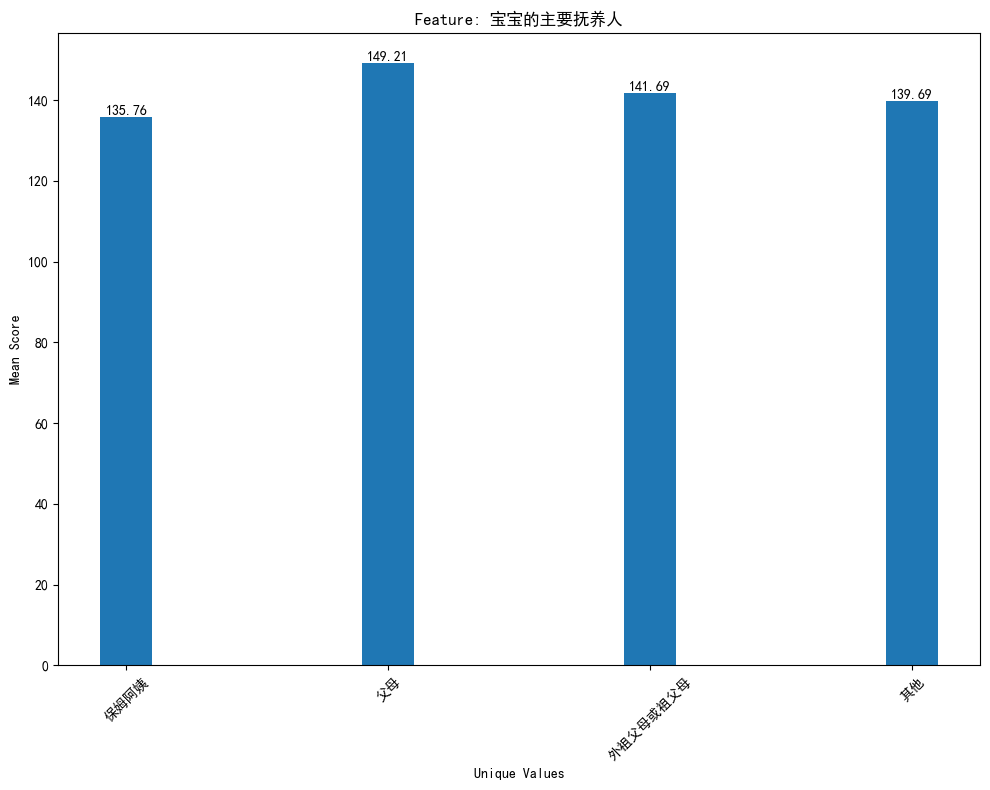

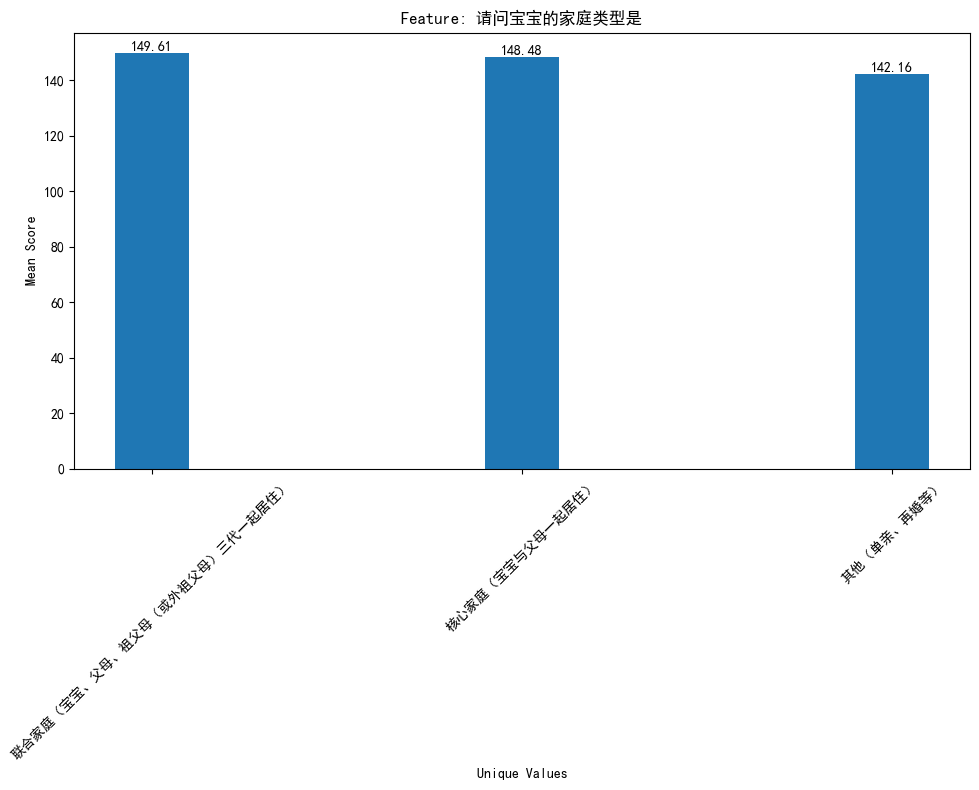

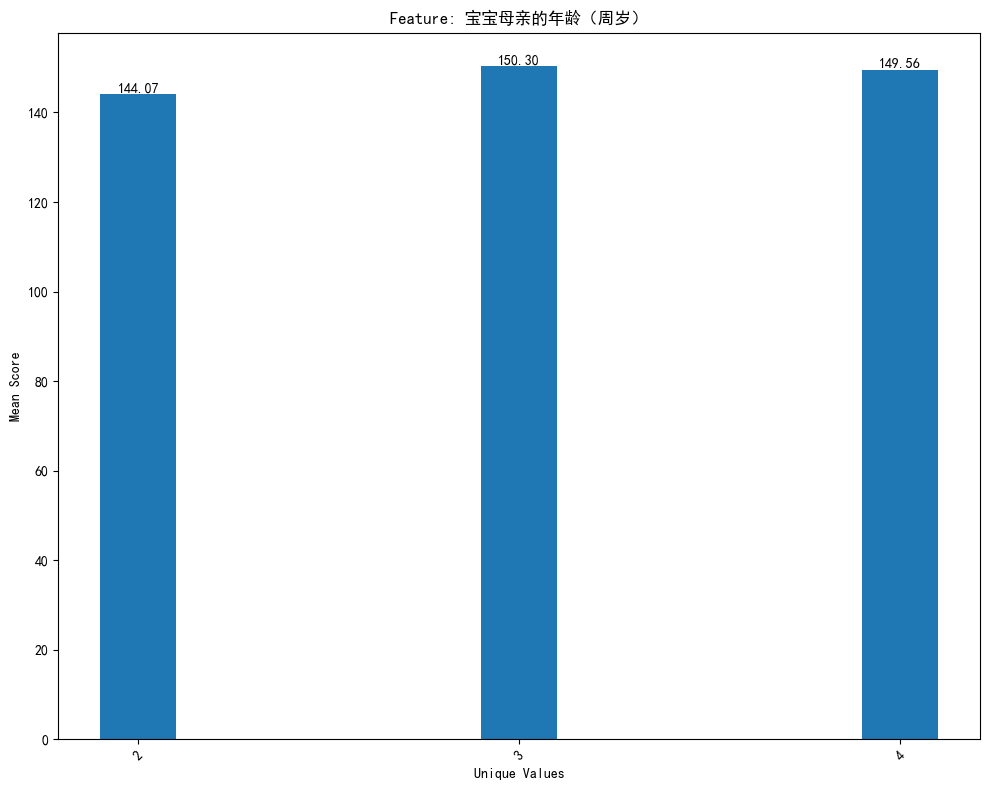

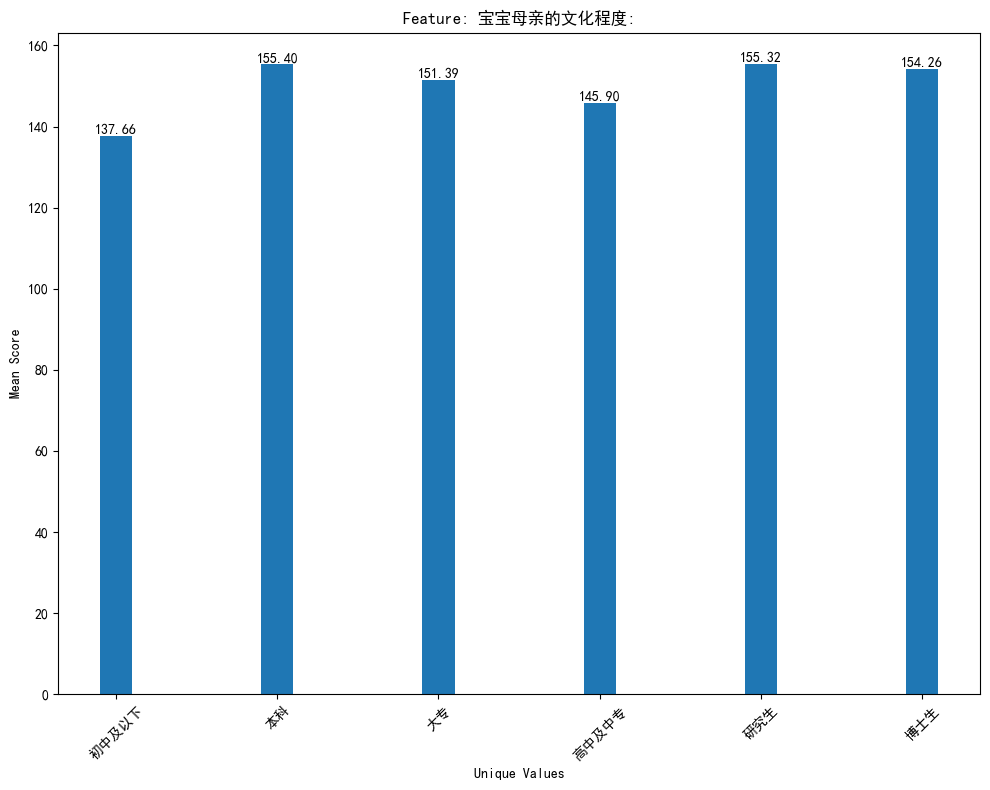

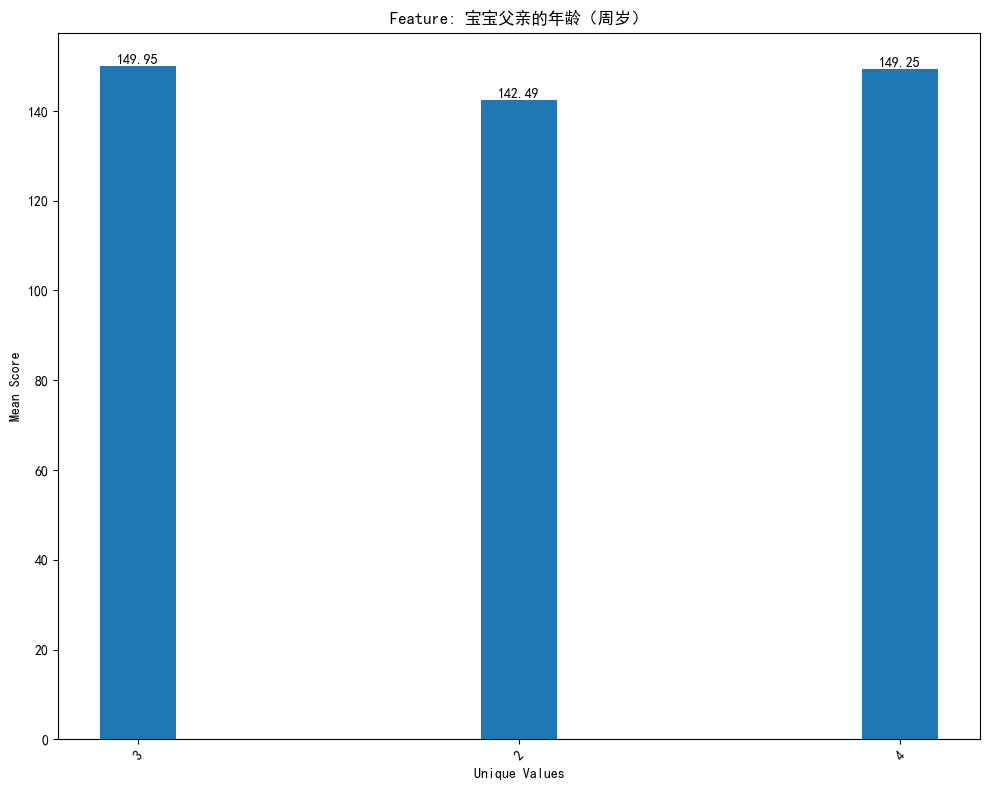

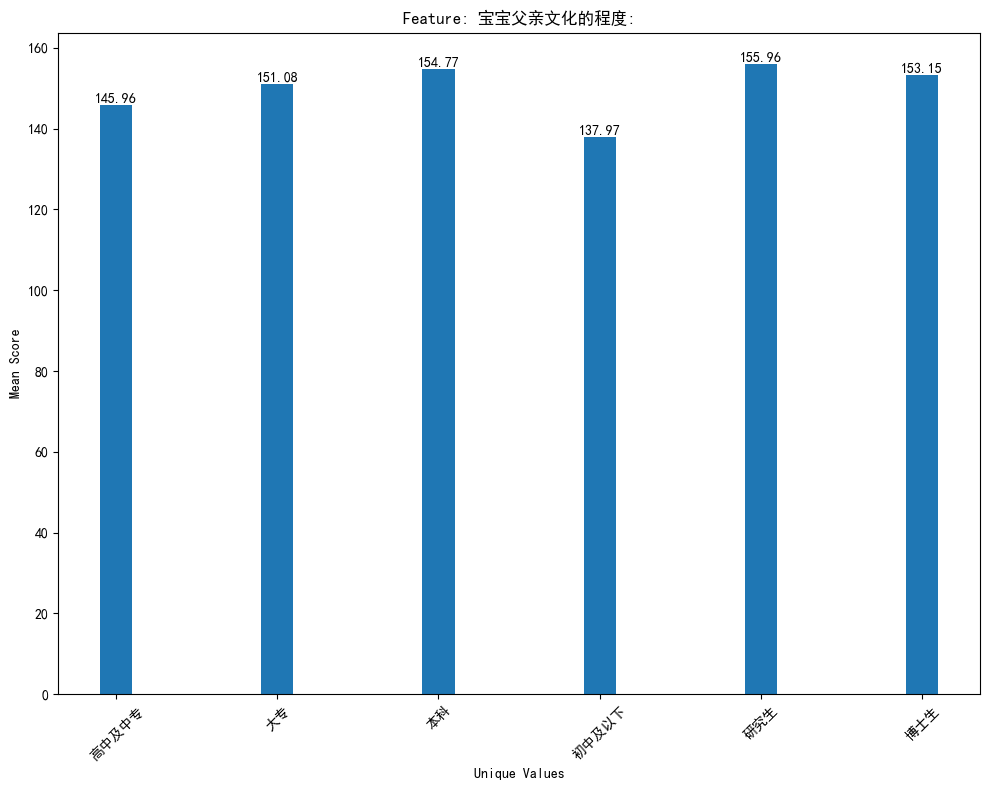

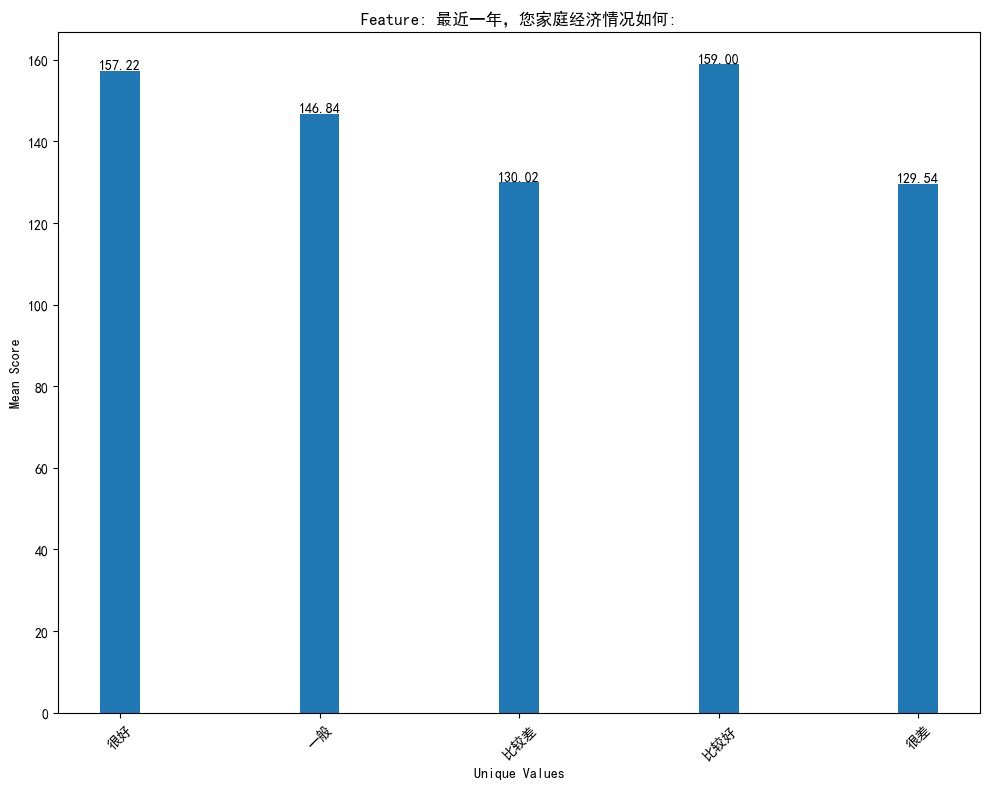

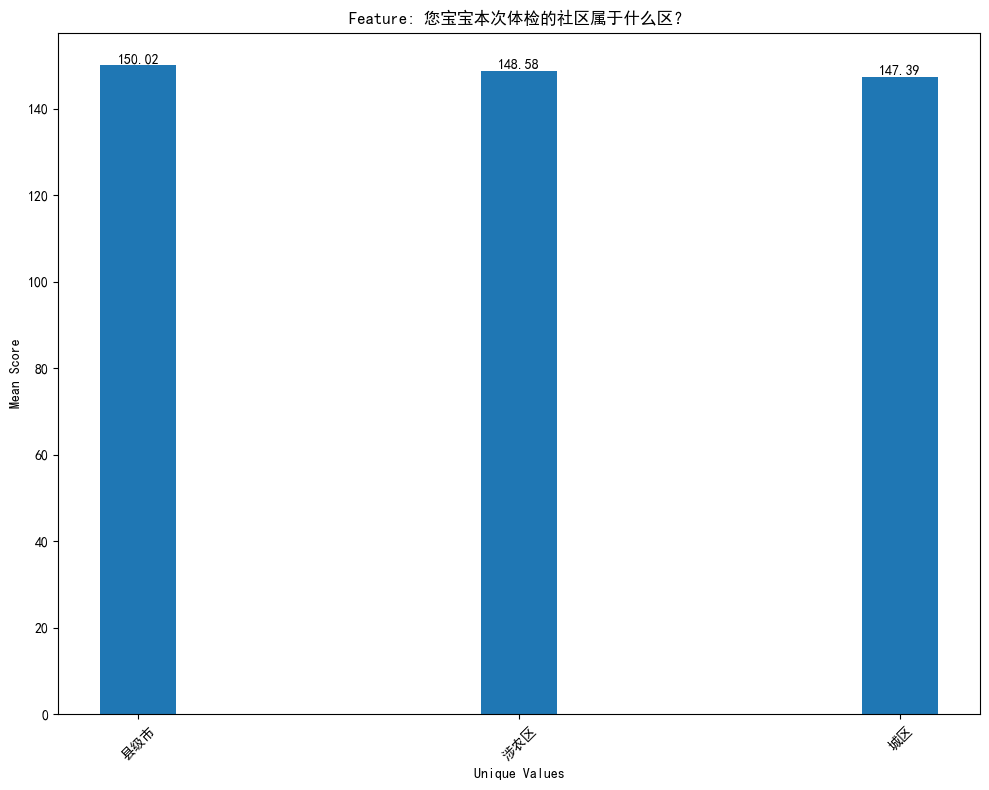

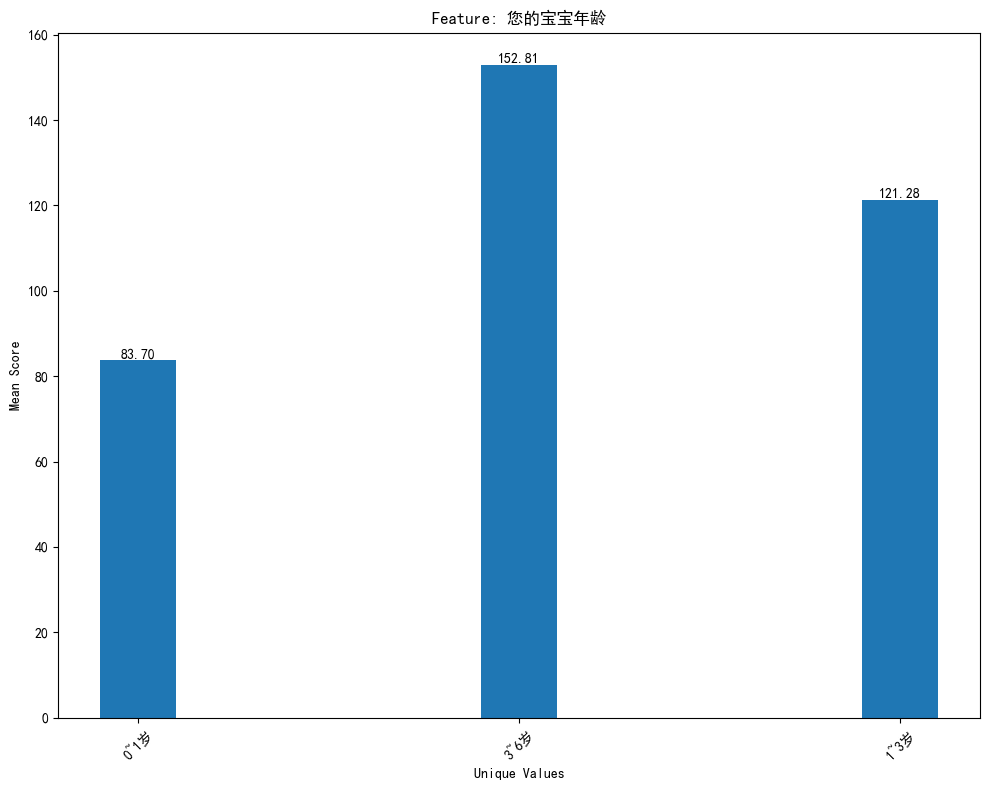

In [95]:
import matplotlib.pyplot as plt

# 设置Matplotlib的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 假设data是一个DataFrame，其中包含了各个特征和总分
# 假设target是一个DataFrame，包含了总分
# feature[1:base_info_idx] 包含了需要分类的特征名

cnt = 0
for feature_name in feature[1:base_info_idx]:
    cnt += 1
    unique_values = data[feature_name].unique()
    scores_means = []
    for value in unique_values:
        # 根据当前特征值筛选数据
        selected_data = data[data[feature_name] == value]
        # 获取这些数据的索引
        selected_indices = selected_data.index
        # 根据索引获取总分
        selected_scores = target.iloc[selected_indices]
        # 计算平均分
        mean_score = selected_scores.mean().values[0]
        scores_means.append(mean_score)
        
    
    # 绘制条形图
    plt.figure(figsize=(10, 8))
    # plt.bar(range(len(unique_values)), scores_means, tick_label=[encoder(v, dicList[cnt]) for v in unique_values], width=0.2)
    bars = plt.bar(range(len(unique_values)), scores_means, tick_label=[encoder(v, dicList[cnt]) for v in unique_values], width=0.2)
    plt.title(f'Feature: {feature_name}')
    plt.xlabel('Unique Values')
    plt.ylabel('Mean Score')
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

### 随机森林

由于目标和特征之间是相关的，我认为不能用随机森林输出特征重要性（或者说不能解释）  
此处为测试其可行性

In [96]:
X = data.iloc[:, base_info_idx:]
y = target

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # 或 RandomForestClassifier，取决于y的类型
from sklearn.metrics import mean_squared_error  # 或 accuracy_score，取决于y的类型
import pandas as pd

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化随机森林模型
model = RandomForestRegressor(n_estimators=200, max_leaf_nodes=30 ,random_state=42, n_jobs=6)  # 或 RandomForestClassifier，取决于y的类型

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 输出特征重要性
feature_importances = pd.Series(model.feature_importances_, index=feature[base_info_idx:])
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


赞赏孩子的好奇心，有意识培养孩子兴趣       0.552792
对孩子的需求能够作出及时的回应.1        0.096218
引导孩子探索认识各种事物间的相互关系       0.089429
鼓励孩子尽量用语言表达自己            0.061766
和孩子进行目光、言语的交流            0.053404
                           ...   
有多个可供儿童活动的房间             0.000000
延迟满足孩子要求，有意识锻炼孩子的自控能力    0.000000
带孩子到商店、公园，参观各种展览         0.000000
引导孩子和其他儿童的合作与竞争          0.000000
家庭气氛融洽                   0.000000
Length: 126, dtype: float64

In [58]:
mean_col = data.iloc[:, base_info_idx:].mean(axis=0).sort_values(ascending=False)
var_col = data.iloc[:, base_info_idx:].var(axis=0).sort_values(ascending=False)
print(mean_col, end='\n\n')
print(var_col)

拥抱、爱抚孩子                     4.084023
感到孩子可爱，愿意和孩子在一起             4.038138
有意识按照公共准则引导和规范孩子的行为.1       4.028921
鼓励孩子生活自理(吃饭、穿衣、洗漱)          4.007399
对孩子的良好行为及时进行肯定、鼓励           4.007399
                              ...   
为家庭或孩子的事情而争吵               -2.103154
用恐怖的意象或故事(如大灰狼)吓阻孩子的自主行为   -2.128375
感到带孩子很累、很烦.1               -2.226828
对孩子任何事情都要干涉                -2.241748
经常强迫孩子多吃一点                 -2.259570
Length: 126, dtype: float64

有多个可供儿童活动的房间.1              2.275670
引导孩子和其他儿童的合作与竞争             2.201623
孩子活动的房间光线明亮，布置得丰富多彩.1       2.181112
3~6岁儿童家庭养育环境问卷—对家庭生活感到满意    2.141024
拥有足量适合孩子年龄阅读的图书             2.107101
                              ...   
终日在外忙碌，很少有时间见到孩子            0.139424
为了家庭或孩子的事情争吵、闹别扭            0.126282
凭自己心情对孩子忽冷忽热                0.113460
把孩子捆扎得很紧，孩子四肢手足难以活动         0.085083
不太喜欢孩子，不愿和孩子在一起             0.084438
Length: 126, dtype: float64


下面输出以feature_importances降序排序，每一项的 mean 和 var

可以看出 ``feature_importances`` ``mean`` ``var`` 完全没有规律  
但是可以看出，mean 和 var 较小的特征，feature_importances都不会太高，这也印证了我之前的一个想法:  
总分由各项特征代数加和而来，因此如果将总分看成独立的，输入进机器学习模型，那么模型所展示的每个特征重要程度，应该是同等重要（代数加和无权重）

而 ``mean`` 和 ``var`` 较大的特征，节点分裂一次更容易降低不纯度，导致看起来 ``feature_importances`` 高一些。  
总之，随机森林是一种基于树的模型，它在处理非线性关系方面非常有效，但对于这种直接的线性关系，特征重要性可能不会提供额外的洞见，因为所有特征对于预测标签来说几乎同等重要。

另外一点，随机森林节点分裂还具有随机性，不同超参输出的特征重要性不同。

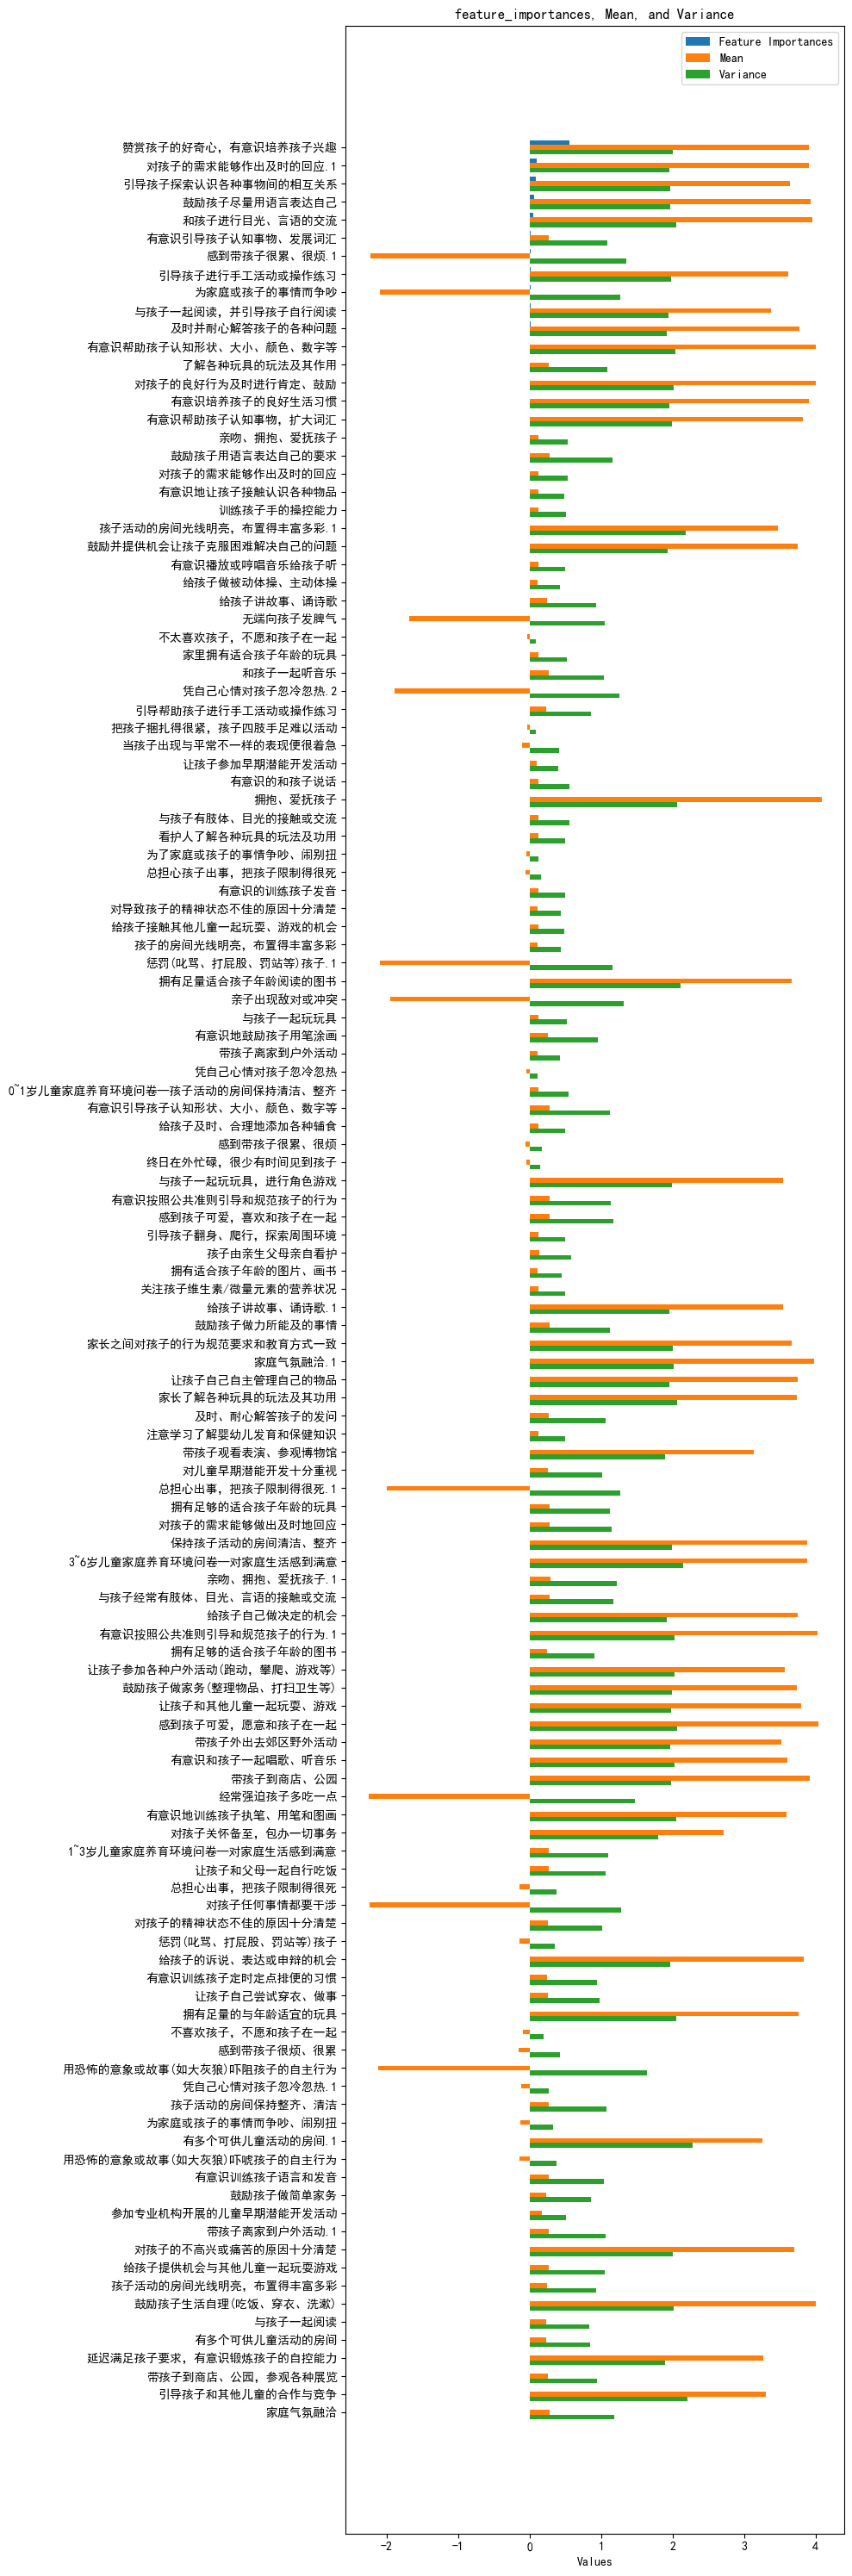

In [108]:
# 绘制图形
columns = feature_importances.index

# 计算条形图的位置，增加条形图之间的间隔
n_groups = len(columns)
index = np.arange(n_groups) * 1.5  # 增加乘数以增加间隔
bar_width = 0.4

# 绘制条形图，调整figsize以适应更大的间隔
fig, ax = plt.subplots(figsize=(10, 30))
bar1 = ax.barh(index, feature_importances, bar_width, label='Feature Importances')
bar2 = ax.barh(index + bar_width, mean_col.reindex(columns), bar_width, label='Mean')
bar3 = ax.barh(index + 2*bar_width, var_col.reindex(columns), bar_width, label='Variance')

# 设置y轴
ax.set_yticks(index + bar_width)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # 使得第一个条形图在最上方

# 设置图例
ax.legend()

# 设置标题和轴标签
ax.set_xlabel('Values')
ax.set_title('feature_importances, Mean, and Variance')

plt.tight_layout()
plt.show()

此处再可视化一下mean和var

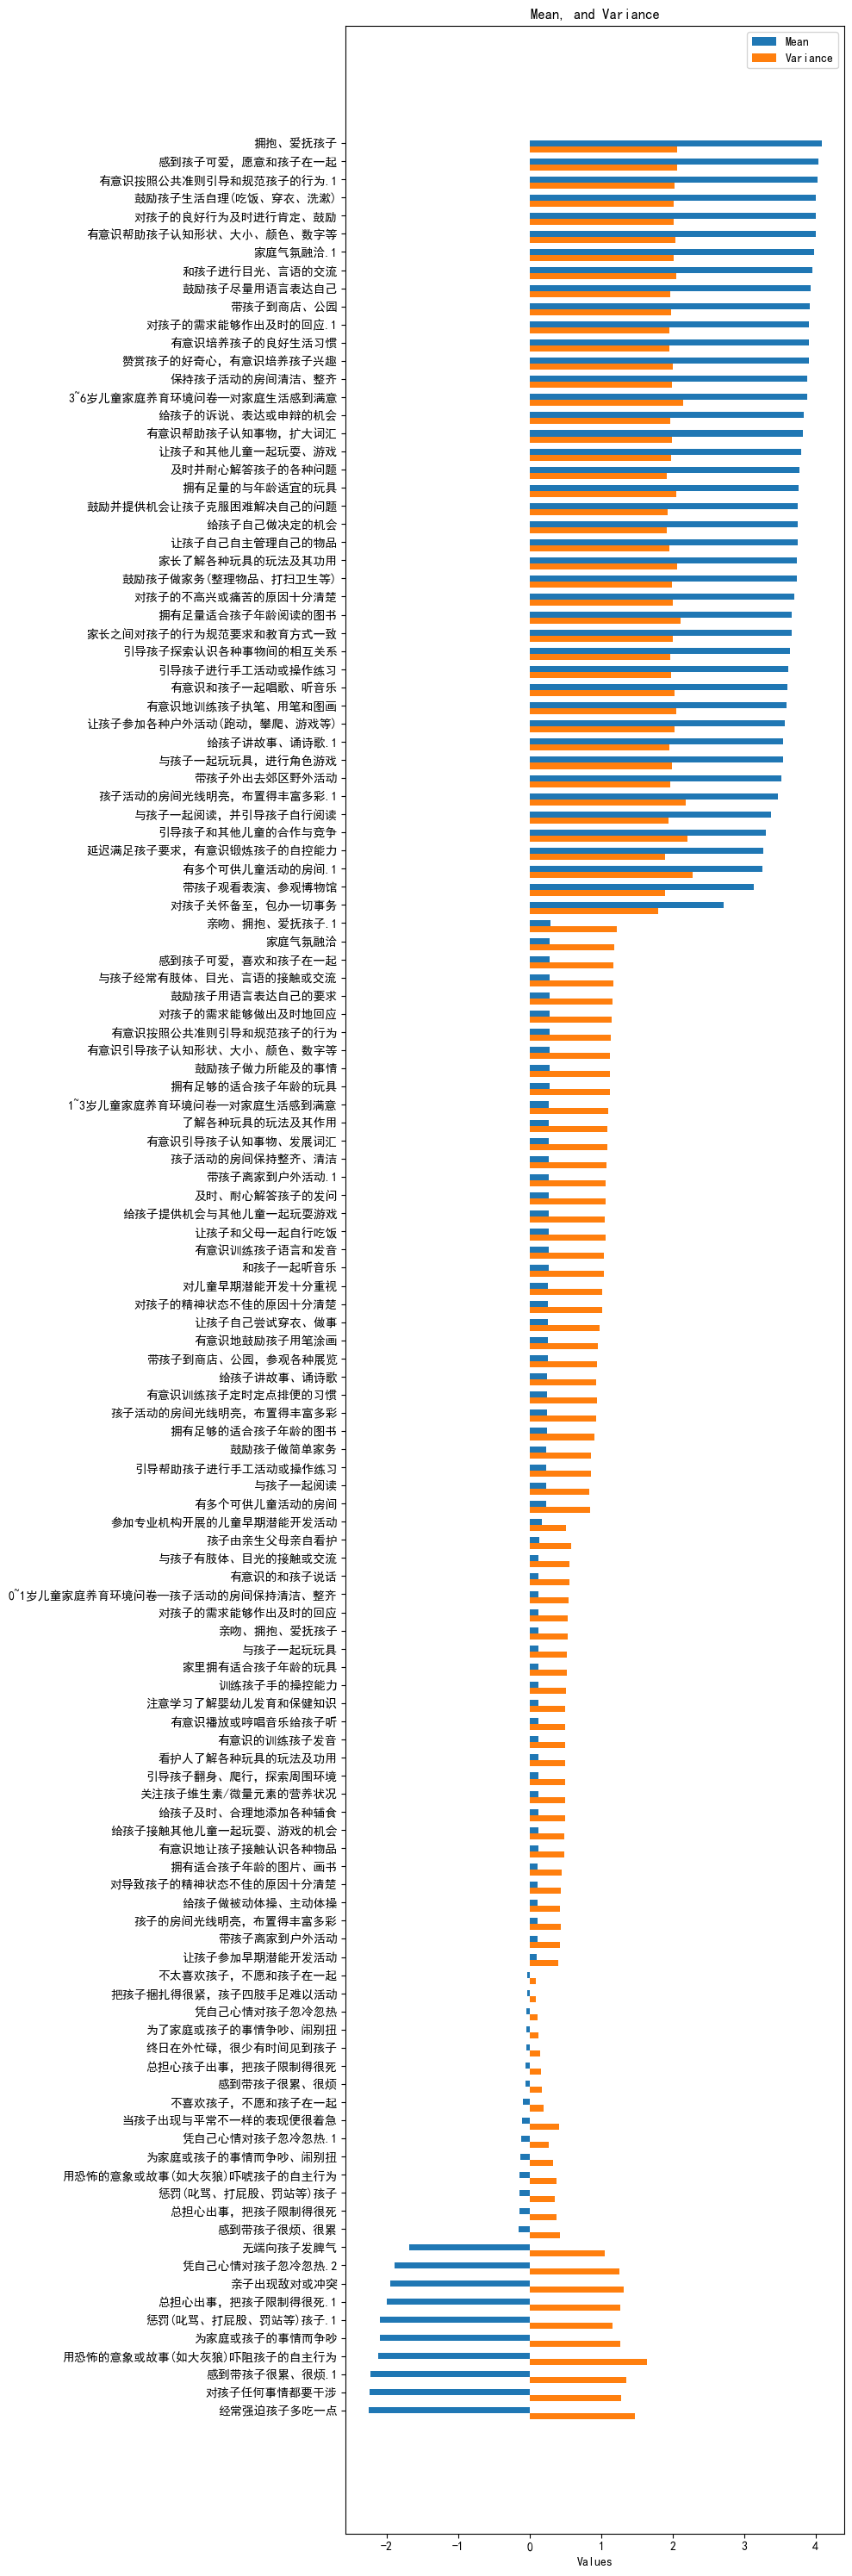

In [109]:
# 绘制图形
columns = mean_col.index

# 计算条形图的位置，增加条形图之间的间隔
n_groups = len(columns)
index = np.arange(n_groups) * 1.5  # 增加乘数以增加间隔
bar_width = 0.5

# 绘制条形图，调整figsize以适应更大的间隔
fig, ax = plt.subplots(figsize=(10, 30))
bar2 = ax.barh(index + bar_width, mean_col, bar_width, label='Mean')
bar3 = ax.barh(index + 2*bar_width, var_col.reindex(mean_col.index), bar_width, label='Variance')

# 设置y轴
ax.set_yticks(index + bar_width)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # 使得第一个条形图在最上方

# 设置图例
ax.legend()

# 设置标题和轴标签
ax.set_xlabel('Values')
ax.set_title('Mean, and Variance')

plt.tight_layout()
plt.show()